In [277]:
#importamos librerias
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [278]:
#para visualizar dos series de datos: los valores reales y las predicciones hechas por el modelo.
def graficar_predicciones(real, prediccion):
    #raficar los valores reales
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción') #real[0:len(prediccion)]: Esta expresión se asegura de que solo se tracen tantos valores reales como haya predicciones, para que las series tengan la misma longitud y puedan compararse adecuadamente.
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    #Ajustar los límites del eje Y
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion)) #1.1 * np.min(prediccion)/2: El límite inferior se establece un poco por debajo (en este caso, a la mitad de la distancia al mínimo de las predicciones, escalado por un factor de 1.1 para dar un poco de margen) del valor mínimo de las predicciones.
    #etiquetas
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()



In [295]:
#cargar datos
#importamos a un dataframe

df = pd.read_csv(r"C:\Users\ninic\OneDrive - Lambton College\Term 1\BDM 1113-NoSQL data Base\project\Project-Data-Analysis-Lambton\Electricity_Generation.csv", header=None, names=range(47))
#nombre de las tablas
table_names = ["Canada", "Newfoundland and Labrador", "Prince Edward Island", "Nova Scotia", "New Brunswick","Quebec", "Ontario","Manitoba", "Alberta", "British Columbia", "Saskatchewan", "Yukon", "Northwest Territories", "Nunavut"]
# Identificar grupos basados en los nombres de las tablas
groups = df[0].isin(table_names).cumsum()
# Crear un diccionario de DataFrames para cada tabla
tables = {g.iloc[0,0]: g.iloc[1:-1, :20] for k,g in df.groupby(groups)} 


#acomodar datos
#selecciono una sola region 
df2 = tables["Canada"]
#eliminar primera fila porque los anos estaban en esa fila
df2 = df2.iloc[1:, :]
#eliminar esa columna
df2.drop(df2.columns[0], axis=1, inplace=True)
# Renombrar las columnas del 2005 al 2023
nuevos_nombres = {str(anio): f'Titulo_{anio}' for anio in range(2005, 2024)}
# Asignar nuevos nombres a las columnas
df2.columns = nuevos_nombres
#reset index
df2 = df2.reset_index(drop=True)
#nuevos nombres index
ind_nombres = ["Hydro / Wave / Tidal", "Wind", "Biomass / Geothermal","Solar","Uranium","Coal & Coke","Natural Gas","Oil"]  
df2.rename(index=dict(enumerate(ind_nombres)), inplace=True)
#transponer matriz
dataset = df2.T
#cambiar los numeros a fecha
dataset.index = pd.to_datetime(dataset.index, format='%Y')
#seleccionamos que solo sea WIND y lo pasamos de serie a dataframe 
dataset=dataset["Wind"].to_frame()
#print(type(dataset))
#print(dataset)


<function __main__.cargar_datos()>

<class 'pandas.core.frame.DataFrame'>


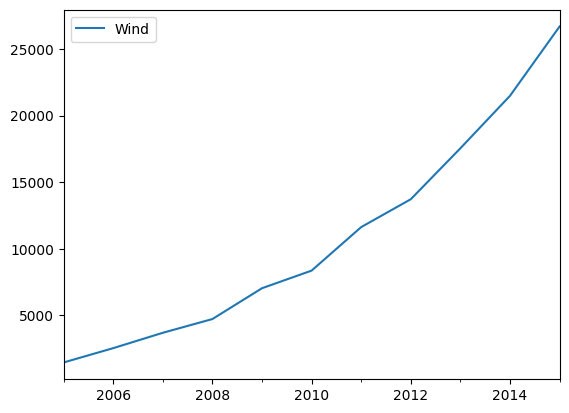

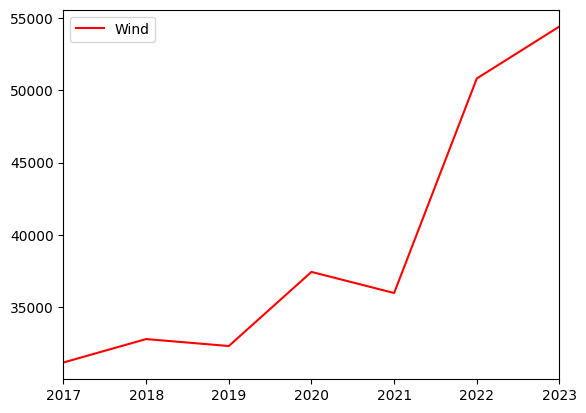

In [280]:
# Sets de entrenamiento y validación 
# La LSTM se entrenará con datos de 2016 hacia atrás. La validación se hará con datos de 2017 en adelante.
# En ambos casos sólo se usará el valor más alto de la acción para cada día
set_entrenamiento = dataset.iloc[:11]
print(type(set_entrenamiento))
#print(set_entrenamiento)
set_validacion = dataset.iloc[12:19]
#print(set_validacion)

set_entrenamiento.plot(legend=True)
set_validacion.plot(legend=True,color='red',label='validacion')
#plt.legend(['Entrenamiento (2005-2020)', 'Validación (2020-2023)'])
plt.show()

In [281]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1)) #Este es un método de escalado que transforma cada característica individualmente de tal forma que esté en el rango dado feature_range=(0,1) significa que después del escalado, todos los valores estarán entre 0 y 1.
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento) #Este es un método de escalado que transforma cada característica individualmente de tal forma que esté en el rango dado
#print(set_entrenamiento_escalado)

In [282]:
# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 3 # lo que indica que para cada punto de predicción, el modelo debería mirar los 10 pasos de tiempo anteriores.
X_train = [] #X_train y Y_train se inicializan como listas vacías, que más tarde se llenarán con los datos de entrenamiento y las etiquetas (targets) respectivamente.
Y_train = []
m = len(set_entrenamiento_escalado) #m es la longitud total del conjunto de entrenamiento escalado, es decir, el número total de ejemplos de entrenamiento disponibles.
#Por ejemplo, si time_step es 60, el primer elemento de X_train contendrá los datos de set_entrenamiento_escalado de la posición 0 a 59 (60 elementos), 
#y el primer elemento de Y_train contendrá el dato en la posición 60.
"""El propósito de este bucle for es crear secuencias de datos de longitud time_step que servirán como entradas (X_train) para el modelo,
 y recopilar el valor que sigue inmediatamente después de cada secuencia como la etiqueta o valor objetivo (Y_train) que el modelo intentará predecir."""
for i in range(time_step,m):
    print(i)
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])

#Las listas X_train y Y_train se convierten en arreglos de NumPy, lo cual es necesario para poder trabajar con las funciones de entrenamiento de modelos de Keras.
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #np.reshape() cambia la forma de X_train a la forma necesaria para la entrada en la red LSTM. Las LSTM esperan una entrada 3D con la forma [muestras, pasos de tiempo, características].
#X_train.shape[0] es el número total de ejemplos de entrenamiento (o muestras).
#X_train.shape[1] es el número de pasos de tiempo (en este caso, 60).
#El 1 al final indica que hay una sola característica por paso de tiempo. Esto es común en series temporales univariantes, donde en cada momento se registra una sola observación.

3
4
5
6
7
8
9
10


In [283]:
# Red LSTM
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 100
""" dim_entrada: Se define la dimensión de entrada para la red LSTM. Se basa en la forma de X_train que, como hemos reformateado anteriormente, es (número de muestras, 60, 1). La dimensión de entrada es el tamaño de cada secuencia de entrada (60, 1), donde 60 es el número de pasos de tiempo y 1 es el número de características por paso de tiempo.
dim_salida: Define el tamaño de la capa de salida, que es 1. Esto significa que el modelo predecirá un único valor continuo (por ejemplo, el siguiente punto en una serie temporal).
na: Número de unidades o neuronas en la capa LSTM. Se ha elegido un tamaño de 50, lo que significa que habrá 50 bloques de memoria LSTM en esta capa, cada uno de los cuales puede aprender a identificar y mantener un patrón diferente en la secuencia de datos.
 """
modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
""" 
Sequential(): Crea un modelo secuencial en Keras, que es un modelo lineal de capas donde se añaden una tras otra.
add(LSTM(units=na, input_shape=dim_entrada)): Añade una capa LSTM al modelo con 50 unidades. input_shape se define con la variable dim_entrada, lo que indica que cada muestra de entrada al modelo será de tamaño (60, 1).
add(Dense(units=dim_salida)): Añade una capa densa (o completamente conectada) al modelo, que tiene una única unidad. Esta es la capa de salida que produce la predicción final. """
modelo.compile(optimizer='rmsprop', loss='mse')
""" compile(): Configura el modelo para el entrenamiento.
optimizer='rmsprop': Selecciona el optimizador RMSprop, que es una buena opción para redes recurrentes, como las LSTM. 
loss='mse': Se establece la función de pérdida como el error cuadrático medio (mse), que es típico para problemas de regresión. """
modelo.fit(X_train,Y_train,epochs=100,batch_size=150)
""" fit(): Entrena el modelo con los datos proporcionados.
X_train, Y_train: Los datos de entrenamiento y las etiquetas correspondientes.
epochs=20: Indica que el modelo debe pasar por los datos completos 20 veces. Una "época" es una pasada completa a través del conjunto de entrenamiento.
batch_size=32: Define el tamaño del lote como 32, lo que significa que 32 muestras se procesarán antes de actualizar los parámetros del modelo. """



Epoch 1/100


c:\Users\ninic\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.3184
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2732
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2427
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2181
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1969
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1779
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1607
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1447
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1300
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1164
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1038
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0922
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0816
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0719
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0633
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

' fit(): Entrena el modelo con los datos proporcionados.\nX_train, Y_train: Los datos de entrenamiento y las etiquetas correspondientes.\nepochs=20: Indica que el modelo debe pasar por los datos completos 20 veces. Una "época" es una pasada completa a través del conjunto de entrenamiento.\nbatch_size=32: Define el tamaño del lote como 32, lo que significa que 32 muestras se procesarán antes de actualizar los parámetros del modelo. '

In [284]:
#Validación (predicción del valor de las acciones)
x_test = set_validacion.values
x_test = sc.transform(x_test)
#print(x_test)
""" Primero, tomas los valores del DataFrame set_validacion y los conviertes en un array de NumPy usando .values.
 Esto es necesario porque el MinMaxScaler (sc) y los modelos de Keras trabajan con arrays de NumPy.
Luego, utilizas el MinMaxScaler (sc), que fue previamente ajustado con los datos de entrenamiento, para transformar x_test. 
Esto asegura que los datos de validación estén en la misma escala que los datos con los
 que se entrenó el modelo, lo cual es crucial para que las predicciones sean correctas y comparables. """

X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
    #X_test.append(x_test[i,0])
    #print(X_test)
"""Aquí, creas secuencias de datos de validación que el modelo puede usar para hacer predicciones.
 Para cada índice i desde time_step hasta la longitud de x_test, extraes una secuencia de longitud time_step 
 y la agregas a la lista X_test. Este proceso es similar al que hiciste para los datos de entrenamiento, preparando las 
 secuencias de forma que cada una sea usada por el modelo para generar una predicción"""
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

"""Conviertes X_test en un array de NumPy y luego cambias su forma para que tenga tres dimensiones, 
que es el formato que espera el modelo LSTM ([muestras, pasos de tiempo, características]).
 La dimensión de características es 1 porque estás trabajando con series temporales univariantes.
"""
if len(X_test) > 0:
    prediccion = modelo.predict(X_test)
    prediccion = sc.inverse_transform(prediccion)
else:
    print("No hay suficientes datos para generar predicciones.")



c:\Users\ninic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


                Wind  Wind_prediction
2020-01-01  37454.07     49626.734375
2021-01-01  35996.13     51996.140625
2022-01-01  50816.97     53701.527344
2023-01-01  54408.92     60631.039062


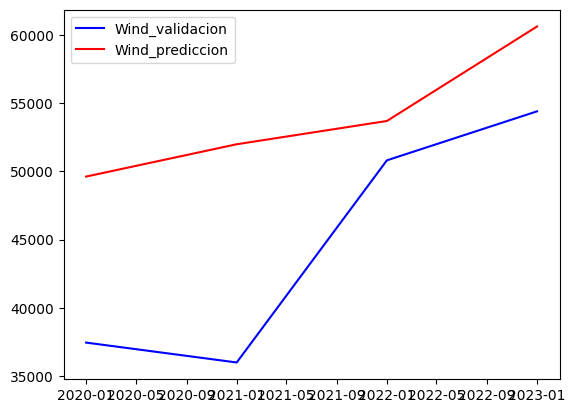

In [292]:

prediction_length = len(prediccion)
validation_length = len(set_validacion)
new_length = validation_length - prediction_length

# Ensure that validation_set is a DataFrame
adjusted_validation_set = set_validacion.iloc[new_length:].copy()
index_names = adjusted_validation_set.index

# Convert prediction to DataFrame and adjust the column name
prediction_df = pd.DataFrame(prediccion, columns=["Wind_prediction"])
result = pd.concat([adjusted_validation_set.reset_index(drop=True), prediction_df.reset_index(drop=True)], axis=1)
result.reset_index(drop=True, inplace=True)
result.index = index_names
print(result)

plt.plot(result["Wind"], color='blue', label='Wind_validacion')
plt.plot(result["Wind_prediction"], color='red', label='Wind_prediccion')
plt.legend()
plt.show()





